In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from sklearn.cluster import KMeans
from tqdm import tqdm

In [2]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
model.cuda()
print(model)


datapath = 'D:\Database\\animals\images'
labelfile = "D:\Database\\animals\\name of the animals.txt"
num_classes = 90
id2label = {i:label for i, label in enumerate(open(labelfile, 'r').readlines())}

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

Using cache found in C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main


['dinov2_vitb14', 'dinov2_vitb14_dd', 'dinov2_vitb14_lc', 'dinov2_vitb14_ld', 'dinov2_vitg14', 'dinov2_vitg14_dd', 'dinov2_vitg14_lc', 'dinov2_vitg14_ld', 'dinov2_vitl14', 'dinov2_vitl14_dd', 'dinov2_vitl14_lc', 'dinov2_vitl14_ld', 'dinov2_vits14', 'dinov2_vits14_dd', 'dinov2_vits14_lc', 'dinov2_vits14_ld']


Using cache found in C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [3]:

outputs = []
for img in tqdm(os.listdir(datapath), desc='Extracting features'):
    img_path = os.path.join(datapath, img)
    img = Image.open(img_path)
    img = transform(img).cuda()
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        output = output.squeeze(0)
        output = output.cpu().numpy()
        outputs.append(output)

Extracting features:   0%|          | 0/5399 [00:00<?, ?it/s]A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Extracting features: 100%|██████████| 5399/5399 [01:16<00:00, 70.12it/s]


In [7]:
print('Fit Kmeans')
kmeans = KMeans(n_clusters=num_classes, random_state=0)
labels = kmeans.fit_predict(outputs)
len(labels), labels

Fit Kmeans


o:\Programs\Python\Python3_11_4\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(5399, array([53, 66, 25, ..., 34, 40, 74]))

In [11]:
# t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np  

tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(np.array(outputs))
df = pd.DataFrame(X, columns=['x', 'y'])
df['label'] = labels
df.head()


,x,y,label
0,27.632288,47.272800,53
1,-7.888086,-21.786690,66
2,-53.983498,8.612267,25
3,-40.905472,-50.465996,15
4,-39.153557,-47.913605,15


<Axes: xlabel='x', ylabel='y'>

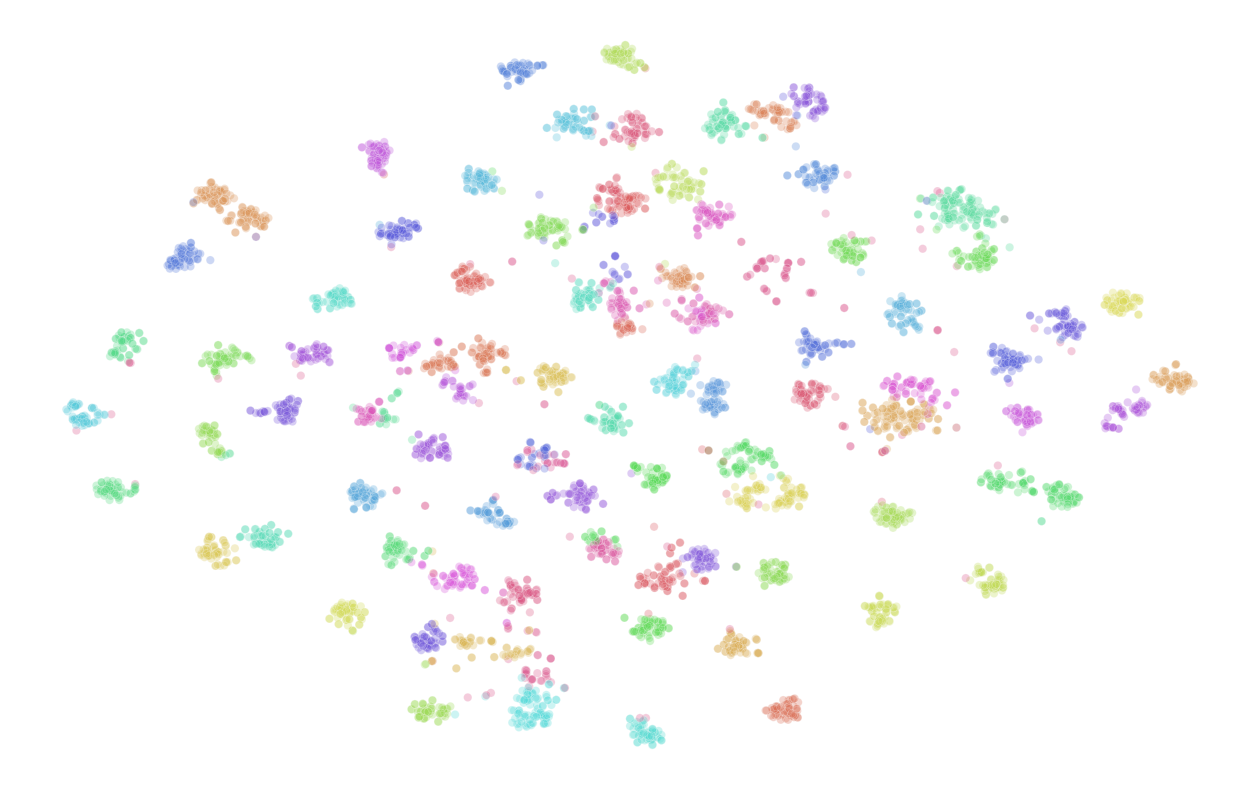

In [17]:

plt.figure(figsize=(16, 10))
plt.axis('off')
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", num_classes),
    data=df,
    legend=None,
    alpha=0.3
)
